In [5]:
%pylab inline
import numpy as np
from parameter import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq

fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\brvhh\anaconda3\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
def advection_rhs(u, t, params):
    
    k,L,x = params    
    temp1 = np.sin(2*x)*u 
    temp2 = (1 -0.5*np.cos(2*x))*ifft(1j*k*fft(u))
    temp3 = 0.3*(ifft(-k**2*fft(u)))
    deriv = temp1 + temp2 + temp3
    return np.real(deriv)

In [7]:
n = 256
m = 256
L = 8

# Set up grid
x = np.linspace(-L,L,n);   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(m,dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
# u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u =  odeint(advection_rhs, u0, t, args=(params,)).T 
#Understanding and preparing the data

#odeint integrates systems of differential equations. 
#The code above produces a system of real numbers where each row corresponds to a different variable
#And each column corresponds to different time points 
#u1 = odeint(advection_rhs, u01, t, args=(params,)).T

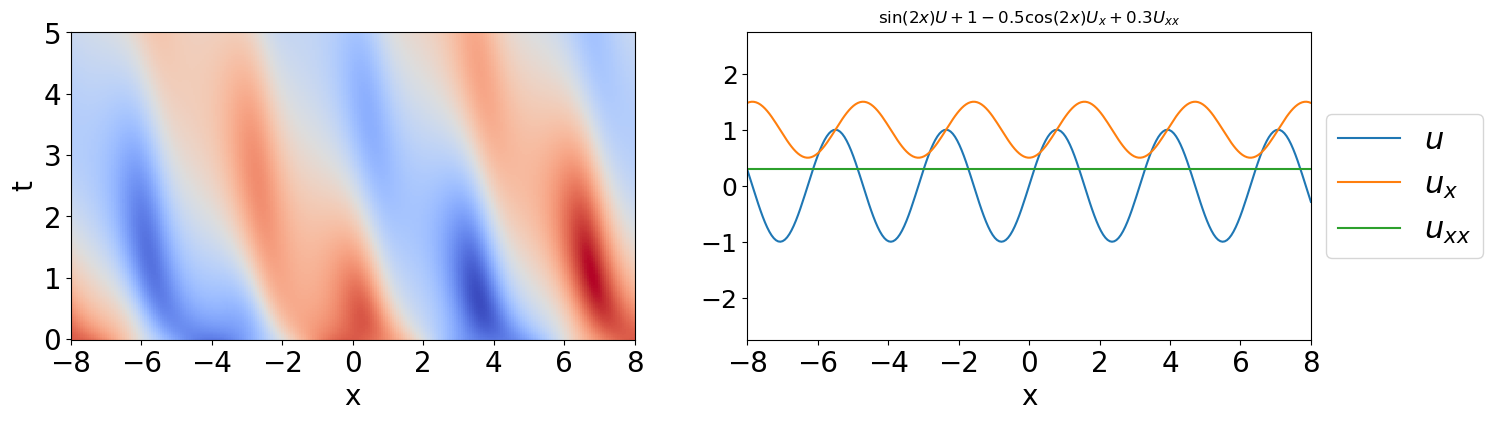

In [8]:
# Plot
u_true =  np.sin(2*x)
u_x_true = (1 -0.5*np.cos(2*x))
u_xx_true = 0.3*np.ones(m)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 2.75]) 
title('$\sin(2x)U + 1-0.5\cos(2x)U_x + 0.3U_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [9]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=2, P=1, time_diff = 'FD', space_diff = 'Fourier')
#In this section we build a linear system (data) for computation
#Feature Engineering

C:\Users\brvhh\OneDrive\Documents\Python Scripts\ProtoCodes\parameter.py:313: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [10]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]
#In this cell we make groupings for our sgtr 

C:\Users\brvhh\OneDrive\Documents\Python Scripts\ProtoCodes\parameter.py:574: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


MSE:  0.09650508576567669


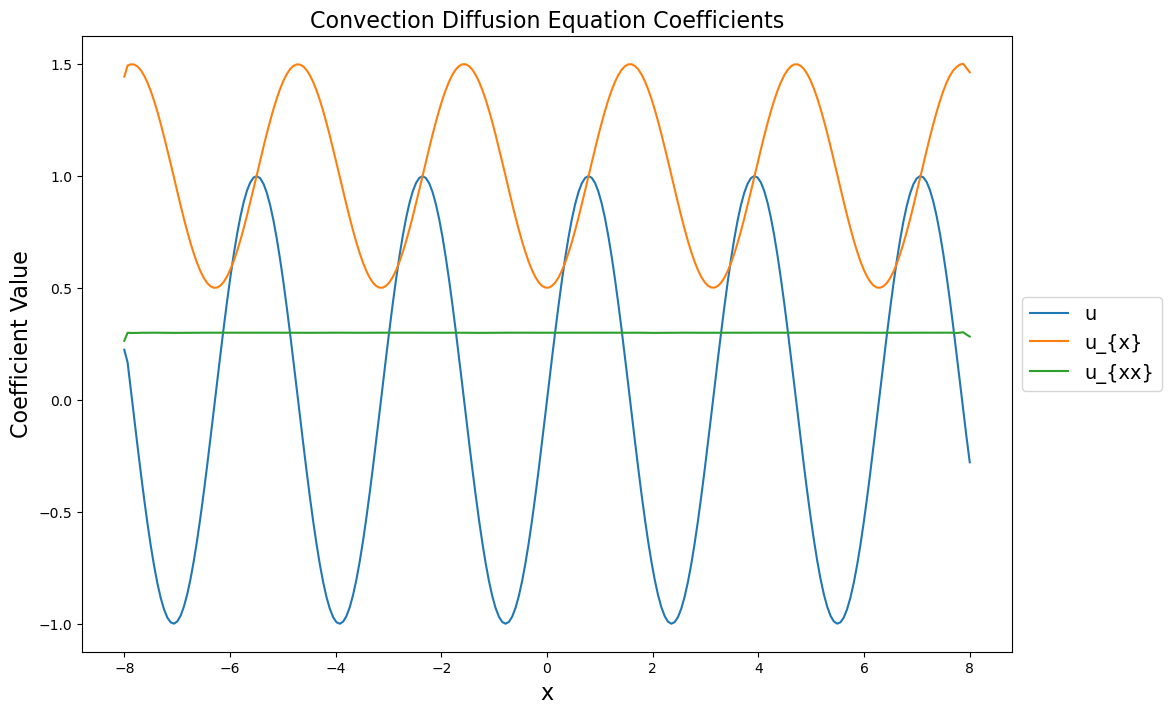

In [11]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]
#Where the solving is done for the optimal values to form the coefficients of the active term 

#Ploting of the active terms begins
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

xi_true = np.zeros((len(rhs_des),m))
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
xi_true[i_u_x,:] = u_x_true

mse_clean_sgtr = Norm(xi-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_sgtr)

In [12]:
un = u + 0.002*std(u)*np.random.randn(n,m)

In [13]:
# Build linear systems
wx = 10  
wt = 10  

#deg_x = 2
#deg_t = None
 
Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=2, P=1, time_diff = 'poly',
                                       deg_x = 6, deg_t = None, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [14]:
# Group by location
Thetan_grouped = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

MSE:  0.08904085386047249


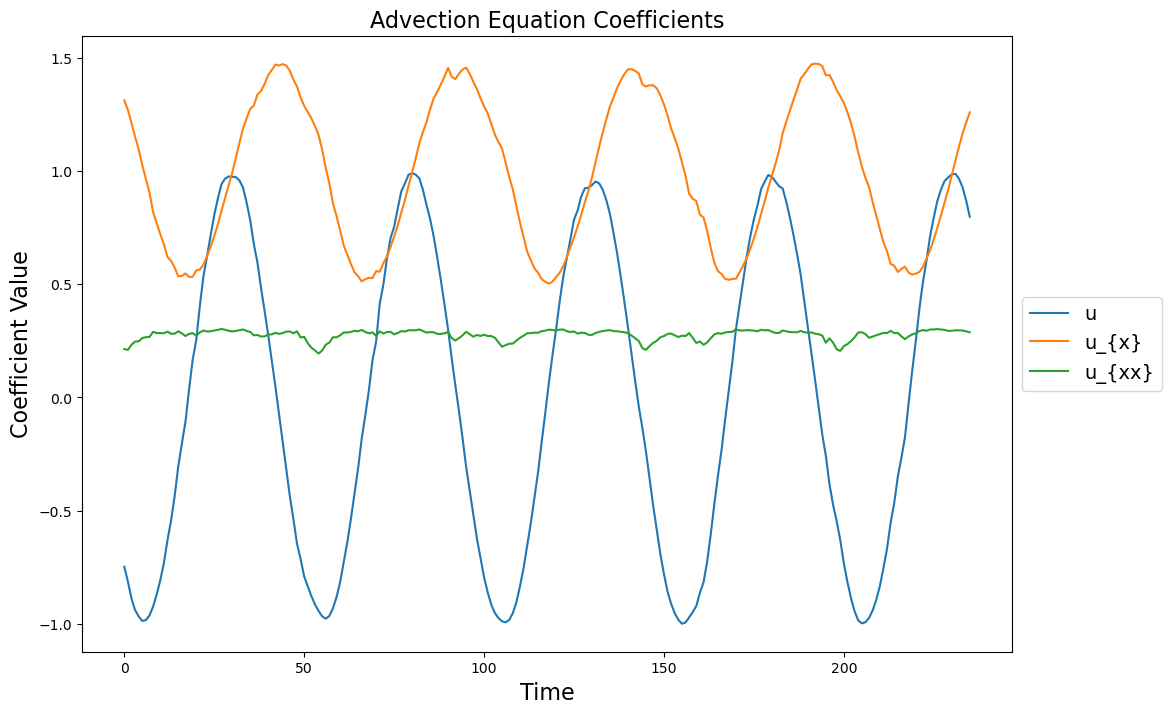

In [15]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[j])

title('Advection Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_n-xi_true[:,wt:-wt])**2/(m*len(rhs_des))
print('MSE: ', mse_noise_sgtr)

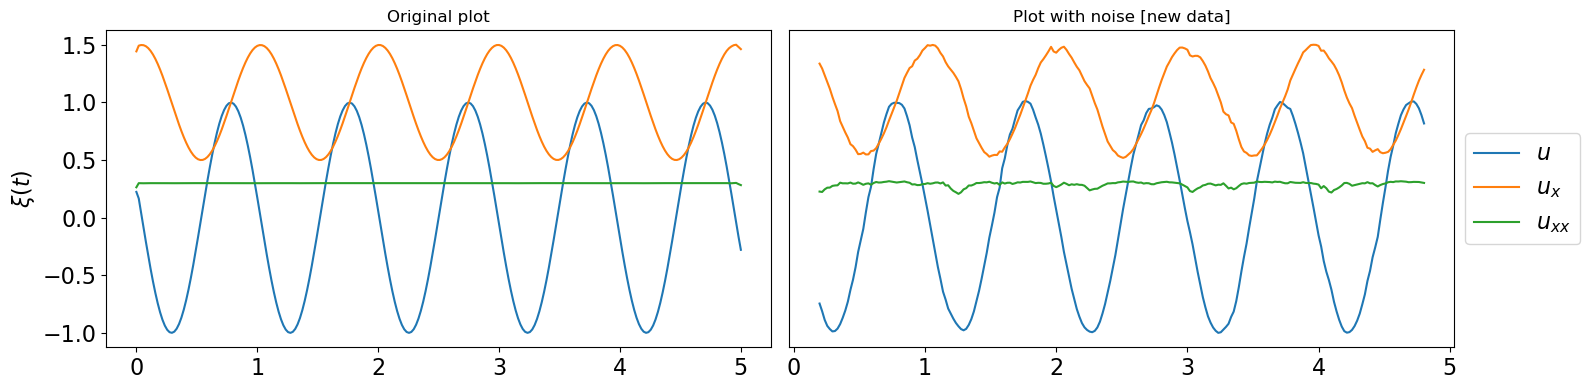

In [16]:
figure(figsize = (16,4))
label_fs = 16

subplot(1,2,1)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(t,xi[j,:], label = rhs_des[j])

ylabel(r'$\xi(t)$', fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)
title("Original plot")

subplot(1,2,2)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(t[wt:-wt],xi_n[j,:], label = '$'+rhs_des[j]+'$')
        
xticks(fontsize = 16)
yticks([], fontsize = 16) 
title("Plot with noise [new data]")

legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 16)

tight_layout()